In [214]:
%run notebook1.ipynb
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from tabulate import tabulate
from calendar import monthrange
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
from calendar import monthrange
import locale
import sys
sys.path.insert(0,'../src')
import file_import
from pickle import load
from datetime import date
import statsmodels.api as sm
import statsmodels.stats.power as smp
from scipy.stats import norm

### Import the DataFrame

In [215]:
crime_df = pd.read_pickle('../data/pickled_df.pkl')

### Inspect the DataFrame

In [216]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7846809 entries, 0 to 7846808
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

In [217]:
crime_df.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN


### Show the Columns in the DataFrame

In [218]:
# This line will show me a list of all the columns
column_list = crime_df.columns.tolist()
print(column_list)

['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']


### Show All Unique Crimes

In [219]:
# All unique values for Primary Type Column
crime_type = crime_df['Primary Type'].unique()
crime_type_counts = crime_df["Primary Type"].value_counts().head(5)
# print(crime_type_counts)
# print(crime_type)

### Show All Unique Crime Locations

In [220]:
# All unique values for Location Description
loc_desc = crime_df['Location Description'].unique()
location_counts = crime_df["Location Description"].value_counts().head(5)
print(location_counts)
print(loc_desc)

STREET       2045225
RESIDENCE    1313506
APARTMENT     891006
SIDEWALK      732097
OTHER         270017
Name: Location Description, dtype: int64
['RESIDENCE' nan 'STREET' 'OTHER' 'GOVERNMENT BUILDING/PROPERTY'
 'POLICE FACILITY/VEH PARKING LOT' 'VACANT LOT/LAND' 'APARTMENT'
 'SIDEWALK' 'HOTEL/MOTEL' 'RESIDENCE-GARAGE' 'BANK'
 'PARKING LOT/GARAGE(NON.RESID.)' 'PARK PROPERTY'
 'HOSPITAL BUILDING/GROUNDS' 'RESTAURANT' 'DAY CARE CENTER'
 'SCHOOL, PUBLIC, BUILDING' 'CHA PARKING LOT/GROUNDS' 'ALLEY'
 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA' 'CTA TRAIN'
 'RESIDENCE PORCH/HALLWAY' 'GAS STATION' 'RESIDENTIAL YARD (FRONT/BACK)'
 'BAR OR TAVERN' 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA'
 'AUTO / BOAT / RV DEALERSHIP' 'CONVENIENCE STORE' 'WAREHOUSE'
 'VEHICLE NON-COMMERCIAL' 'ATHLETIC CLUB' 'POOL ROOM'
 'COMMERCIAL / BUSINESS OFFICE' 'BOAT/WATERCRAFT' 'CTA STATION'
 'MEDICAL/DENTAL OFFICE' 'CHA APARTMENT' 'SMALL RETAIL STORE'
 'AIRPORT/AIRCRAFT' 'TAVERN/LIQUOR STORE' 'DRUG STORE' 'ANI

#### Null Hypothesis Significance Testing Procedure

##### 1. State a scientific yes/no question

##### 2. Take a skeptical stance: state a null hypothesis
- Null Hypothesis (H0): The rate of crimes of Assault occurring in the AM is the same as or greater than the rate of crimes of Assault occurring in the PM. AM >= PM

##### 3. State the opposite of your null hypothesis: the alternative hypothesis
- Alternative Hypothesis (Ha): The rate of crimes of Assault is more common as the PM than in the AM. AM < PM

### This is a one tail test. Only worried if the PM is greater than AM

##### 4. Create a probabilistic model of the situation when the null is true

##### How many times does Assault appear in the dataset?

### Total Assaults In Chicago from 2001-2002

In [221]:
assault_crimes = crime_df['Primary Type'].value_counts()['ASSAULT']
print("Total Assault Crimes:", assault_crimes)

Total Assault Crimes: 512777


### Total Number of Assaults AM/PM

In [222]:
# Convert the "Date" column to a pandas datetime object using the specified format ('%m/%d/%Y %I:%M:%S %p')
crime_df["Date"] = pd.to_datetime(crime_df["Date"], format='%m/%d/%Y %I:%M:%S %p')

# Create a new DataFrame containing only rows where the "Primary Type" is "ASSAULT"
# Select the "Date" and "Primary Type" columns for further analysis
assault_with_date = crime_df.loc[crime_df["Primary Type"] == "ASSAULT", ["Date", "Primary Type"]]

# Create a new column "Time_of_Day" to store whether the crime occurred in the AM or PM
# This is achieved by extracting the hour indicator ("%p") from the "Date" column and formatting it as "AM" or "PM"
assault_with_date["Time_of_Day"] = assault_with_date["Date"].dt.strftime('%p')

# Count the occurrence of "AM" and "PM" in the "Time_of_Day" column to get the number of assaults that occurred in the AM and PM, respectively
assault_counts = assault_with_date["Time_of_Day"].value_counts()

# Store the number of assaults that occurred in the AM and PM in separate variables
assaults_am = assault_counts.loc["AM"]
assaults_pm = assault_counts.loc["PM"]

print("Total Assault Crimes:", assault_crimes)

# Assaults that occurred in the AM
print("Number of Assaults in the AM:", assaults_am)

# Assaults that occurred in the PM
print("Number of Assaults in the PM:", assaults_pm)



Total Assault Crimes: 512777
Number of Assaults in the AM: 169790
Number of Assaults in the PM: 342987


In [223]:
# #  Null Hypothesis (H0): The rate of crimes of Assault occurring in the AM is the same as or greater than the rate of crimes of Assault occurring in the PM. AM >= PM
# # Alternative Hypothesis (Ha): The rate of crimes of Assault is more common as the PM than in the AM. AM < PM

# # scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate',
# #                       permutations=None, random_state=None, alternative='two-sided',
# #                       trim=0, *, keepdims=False)

# stats.ttest_ind(
#     a = assaults_pm, # this is the one we are checking as the alt hyp
#     b = assaults_am, # this is the one we are comparing against
#     equal_var=False, # Choosing welchs which does not care about the varience
#     alternative='greater' # if alt is true, pm will be higher
#     )


### Total Assault Counts AM/PM

In [224]:
print(assault_counts)

PM    342987
AM    169790
Name: Time_of_Day, dtype: int64


In [225]:
# Creates two new dataframes to select rows where the value in the Time of Day Column is AM and PM
# Created with assistance from Shawn and Chad

# Create a new DataFrame "am_df" containing only rows from "assault_with_date" where the "Time_of_Day" is 'AM'
am_df = assault_with_date[assault_with_date['Time_of_Day'] == 'AM']

# Create a new DataFrame "pm_df" containing only rows from "assault_with_date" where the "Time_of_Day" is 'PM'
pm_df = assault_with_date[assault_with_date['Time_of_Day'] == 'PM']

print(am_df)
print(pm_df)

                       Date Primary Type Time_of_Day
210     2017-12-16 09:30:00      ASSAULT          AM
212     2018-02-06 08:01:00      ASSAULT          AM
228     2015-08-05 10:00:00      ASSAULT          AM
361     2007-08-25 09:22:18      ASSAULT          AM
436     2015-09-13 02:45:00      ASSAULT          AM
...                     ...          ...         ...
7846352 2015-03-18 08:15:00      ASSAULT          AM
7846500 2015-03-17 11:54:00      ASSAULT          AM
7846618 2015-06-05 00:45:00      ASSAULT          AM
7846659 2021-07-11 02:07:00      ASSAULT          AM
7846675 2003-09-28 04:15:00      ASSAULT          AM

[169790 rows x 3 columns]
                       Date Primary Type Time_of_Day
227     2015-09-09 19:00:00      ASSAULT          PM
262     2017-12-03 19:00:00      ASSAULT          PM
332     2017-12-25 14:30:00      ASSAULT          PM
348     2015-09-11 15:15:00      ASSAULT          PM
391     2015-09-12 18:00:00      ASSAULT          PM
...                

### Average Time of Day for AM and PM Assults for Entire Time Period

In [226]:
### Used ChatGPT to get this, could not figure it out ###

# Calculate the average time of day for AM assaults
# 1. Calculate the mean (average) hour of the "Date" column in the DataFrame "am_df" using `dt.hour.mean()`.
am_avg_hour = am_df["Date"].dt.hour.mean()

# 2. Calculate the mean (average) minute of the "Date" column in the DataFrame "am_df" using `dt.minute.mean()`.
am_avg_minute = am_df["Date"].dt.minute.mean()

# 3. Calculate the mean (average) second of the "Date" column in the DataFrame "am_df" using `dt.second.mean()`.
am_avg_second = am_df["Date"].dt.second.mean()

# 4. Format the calculated average time of day for AM assaults in the format "HH:MM:SS" using string formatting.
#    The `int()` function is used to convert the calculated average hour, minute, and second to integers,
#    and `:02d` ensures that the numbers are displayed with leading zeros if necessary.
am_avg_time_of_day = f"{int(am_avg_hour):02d}:{int(am_avg_minute):02d}:{int(am_avg_second):02d}"

# Calculate the average time of day for PM assaults
# 5. Calculate the mean (average) hour of the "Date" column in the DataFrame "pm_df" using `dt.hour.mean()`.
pm_avg_hour = pm_df["Date"].dt.hour.mean()

# 6. Calculate the mean (average) minute of the "Date" column in the DataFrame "pm_df" using `dt.minute.mean()`.
pm_avg_minute = pm_df["Date"].dt.minute.mean()

# 7. Calculate the mean (average) second of the "Date" column in the DataFrame "pm_df" using `dt.second.mean()`.
pm_avg_second = pm_df["Date"].dt.second.mean()

# 8. Format the calculated average time of day for PM assaults in the format "HH:MM:SS" using string formatting.
#    The `int()` function is used to convert the calculated average hour, minute, and second to integers,
#    and `:02d` ensures that the numbers are displayed with leading zeros if necessary.
pm_avg_time_of_day = f"{int(pm_avg_hour):02d}:{int(pm_avg_minute):02d}:{int(pm_avg_second):02d}"

# Create a new DataFrame to store the results
# 9. Create a new DataFrame "avg_time_of_day_df" with two columns: 'Time_of_Day' and 'Average Time'.
#    The 'Time_of_Day' column contains the values ['AM', 'PM'], representing the two time periods.
#    The 'Average Time' column contains the calculated average time of day for AM and PM assaults, respectively.
avg_time_of_day_df = pd.DataFrame({
    'Time_of_Day': ['AM', 'PM'],
    'Average Time': [am_avg_time_of_day, pm_avg_time_of_day]
})

# 10. Print the DataFrame "avg_time_of_day_df" to display the calculated average times of day for AM and PM assaults.
print(avg_time_of_day_df)



  Time_of_Day Average Time
0          AM     06:23:02
1          PM     17:23:02


### Average Time of Day By Month for AM and PM Assults

In [227]:
### Used ChatGPT to get this, could not figure it out ###

# Calculate the average time of day for AM assaults by month
# 1. Group the DataFrame "am_df" by the month of the "Date" column using `dt.to_period("M")`.
#    This groups the data by each unique month in the "Date" column.
am_avg_time_of_day_by_month = am_df.groupby(am_df["Date"].dt.to_period("M")).agg({
    # 2. Use a lambda function to calculate the average hour, minute, and second for each group.
    #    The `x` variable represents the DataFrame of each group.
    "Date": lambda x: f"{int(x.dt.hour.mean()):02d}:{int(x.dt.minute.mean()):02d}:{int(x.dt.second.mean()):02d}"
}).rename(columns={"Date": "AM Avg Time of Day"}).reset_index()

# Calculate the average time of day for PM assaults by month
# 3. Group the DataFrame "pm_df" by the month of the "Date" column using `dt.to_period("M")`.
#    This groups the data by each unique month in the "Date" column.
pm_avg_time_of_day_by_month = pm_df.groupby(pm_df["Date"].dt.to_period("M")).agg({
    # 4. Use a lambda function to calculate the average hour, minute, and second for each group.
    #    The `x` variable represents the DataFrame of each group.
    "Date": lambda x: f"{int(x.dt.hour.mean()):02d}:{int(x.dt.minute.mean()):02d}:{int(x.dt.second.mean()):02d}"
}).rename(columns={"Date": "PM Avg Time of Day"}).reset_index()

# Merge the AM and PM average time of day by month
# 5. Merge the DataFrames "am_avg_time_of_day_by_month" and "pm_avg_time_of_day_by_month"
#    based on the "Date" column, using an outer join.
#    This will combine the average time of day for AM and PM assaults for each month.
avg_time_of_day_by_month_df = pd.merge(am_avg_time_of_day_by_month, pm_avg_time_of_day_by_month, on="Date", how="outer")

# 6. Print the DataFrame "avg_time_of_day_by_month_df" to display the calculated average times of day for AM and PM assaults by month.
print(avg_time_of_day_by_month_df)



        Date AM Avg Time of Day PM Avg Time of Day
0    2001-01           06:22:08           17:21:08
1    2001-02           06:21:06           17:21:06
2    2001-03           07:22:07           16:22:07
3    2001-04           06:23:06           17:22:06
4    2001-05           07:24:07           17:22:07
..       ...                ...                ...
266  2023-03           06:24:00           16:23:00
267  2023-04           06:23:00           17:23:00
268  2023-05           06:23:00           17:24:00
269  2023-06           06:23:00           17:24:00
270  2023-07           05:24:00           17:23:00

[271 rows x 3 columns]


### Lineplot Illustrating Monthly Mean Time of Day for AM and PM Assaults

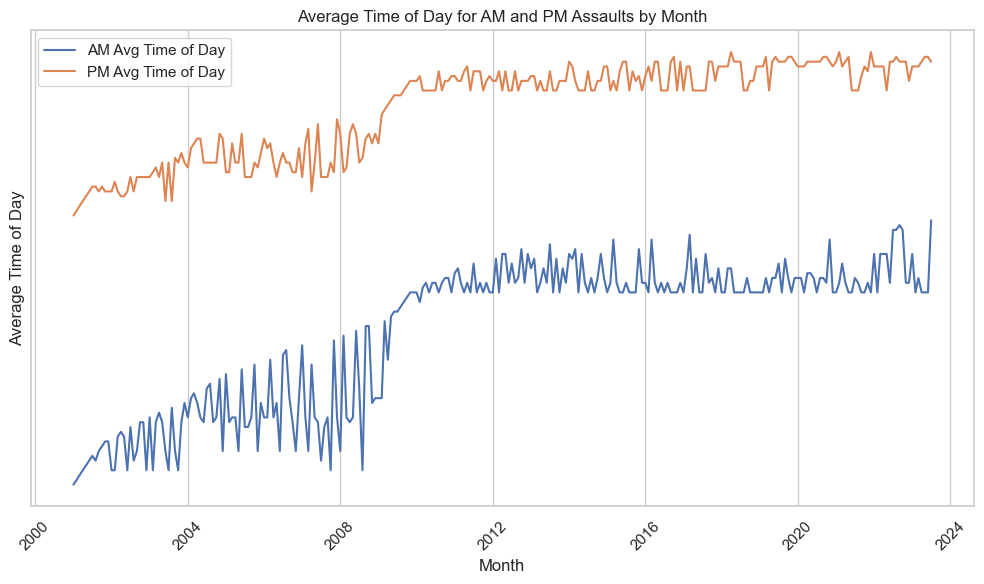

In [228]:
import matplotlib.pyplot as plt

# Assuming you have the avg_time_of_day_by_month_df DataFrame as calculated above

# Convert the "Date" column to a pandas datetime object for proper plotting
avg_time_of_day_by_month_df["Date"] = avg_time_of_day_by_month_df["Date"].dt.to_timestamp()

# Plot the average time of day for AM and PM assaults by month
plt.figure(figsize=(10, 6))
plt.plot(avg_time_of_day_by_month_df["Date"], avg_time_of_day_by_month_df["AM Avg Time of Day"], label="AM Avg Time of Day")
plt.plot(avg_time_of_day_by_month_df["Date"], avg_time_of_day_by_month_df["PM Avg Time of Day"], label="PM Avg Time of Day")

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Average Time of Day")
plt.title("Average Time of Day for AM and PM Assaults by Month")
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Remove y-axis ticks
plt.gca().set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()


### Daily Count of Assaults AM/PM

In [229]:
# This code calculates and prints a daily count of Assault for AM
# 1. Group the DataFrame "am_df" by the date of the "Date" column using `dt.date`.
#    This groups the data by each unique date in the "Date" column.
am_assault_count = am_df.groupby(am_df["Date"].dt.date).count()

# 2. Drop the unnecessary columns "Date" and "Time_of_Day" from the DataFrame "am_assault_count"
#    as they are not needed for the count.
columns_to_drop = ['Date', 'Time_of_Day']
am_assault_count.drop(columns=columns_to_drop, inplace=True)

# 3. Rename the column 'Primary Type' to 'AM Assaults' to represent the count of AM assaults for each date.
am_assault_count.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# 4. Print the DataFrame "am_assault_count" to display the daily count of Assault for AM.
print(am_assault_count)


# This code calculates and prints a daily count of Assault for PM
# 5. Group the DataFrame "pm_df" by the date of the "Date" column using `dt.date`.
#    This groups the data by each unique date in the "Date" column.
pm_assault_count = pm_df.groupby(pm_df["Date"].dt.date).count()

# 6. Drop the unnecessary columns "Date" and "Time_of_Day" from the DataFrame "pm_assault_count"
#    as they are not needed for the count.
columns_to_drop = ['Date', 'Time_of_Day']
pm_assault_count.drop(columns=columns_to_drop, inplace=True)

# 7. Rename the column 'Primary Type' to 'PM Assaults' to represent the count of PM assaults for each date.
pm_assault_count.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# 8. Print the DataFrame "pm_assault_count" to display the daily count of Assault for PM.
print(pm_assault_count)


            AM Assaults
Date                   
2001-01-01           31
2001-01-02           20
2001-01-03           18
2001-01-04           18
2001-01-05           22
...                 ...
2023-07-10           27
2023-07-11           22
2023-07-12           21
2023-07-13           21
2023-07-14           27

[8230 rows x 1 columns]
            PM Assaults
Date                   
2001-01-01           39
2001-01-02           46
2001-01-03           61
2001-01-04           39
2001-01-05           46
...                 ...
2023-07-10           39
2023-07-11           40
2023-07-12           42
2023-07-13           44
2023-07-14           43

[8230 rows x 1 columns]


### Daily Count of Assaults AM/PM

In [230]:
### DON'T MODIFY!! ###
# Calculate the daily count of Assault for AM
am_assault_count_by_day = am_df.groupby(am_df["Date"].dt.date).count()
columns_to_drop = ['Date', 'Time_of_Day']
am_assault_count_by_day.drop(columns=columns_to_drop, inplace=True)
am_assault_count_by_day.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the daily count of Assault for PM
pm_assault_count_by_day = pm_df.groupby(pm_df["Date"].dt.date).count()
columns_to_drop = ['Date', 'Time_of_Day']
pm_assault_count_by_day.drop(columns=columns_to_drop, inplace=True)
pm_assault_count_by_day.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
merged_assault_counts_day = pd.merge(am_assault_count_by_day, pm_assault_count_by_day, left_index=True, right_index=True, how='outer')

# Calculate the daily count of AM Assaults and PM Assaults
daily_count_am_assaults = merged_assault_counts_day['AM Assaults']
daily_count_pm_assaults = merged_assault_counts_day['PM Assaults']

# Calculate the total assaults per day by summing AM and PM assaults for each day
total_assaults_per_day = daily_count_am_assaults + daily_count_pm_assaults

print("Daily Count of AM/PM Assaults:")
print(merged_assault_counts_day)

print("Daily Count of AM Assaults:")
print(daily_count_am_assaults)

print("Daily Count of PM Assaults:")
print(daily_count_pm_assaults)

print("Total Daily Count of Assaults:")
print(total_assaults_per_day)



Daily Count of AM/PM Assaults:
            AM Assaults  PM Assaults
Date                                
2001-01-01           31           39
2001-01-02           20           46
2001-01-03           18           61
2001-01-04           18           39
2001-01-05           22           46
...                 ...          ...
2023-07-10           27           39
2023-07-11           22           40
2023-07-12           21           42
2023-07-13           21           44
2023-07-14           27           43

[8230 rows x 2 columns]
Daily Count of AM Assaults:
Date
2001-01-01    31
2001-01-02    20
2001-01-03    18
2001-01-04    18
2001-01-05    22
              ..
2023-07-10    27
2023-07-11    22
2023-07-12    21
2023-07-13    21
2023-07-14    27
Name: AM Assaults, Length: 8230, dtype: int64
Daily Count of PM Assaults:
Date
2001-01-01    39
2001-01-02    46
2001-01-03    61
2001-01-04    39
2001-01-05    46
              ..
2023-07-10    39
2023-07-11    40
2023-07-12    42
2023-07-13 

### Density Plot of Daily AM and PM Assults

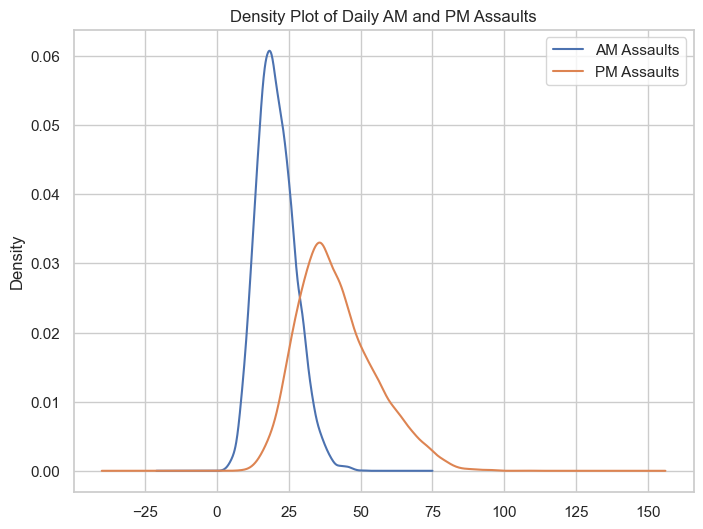

In [231]:
# Combine the AM and PM assault counts into a single DataFrame
daily_assault_counts = pd.DataFrame({
    'AM Assaults': daily_count_am_assaults,
    'PM Assaults': daily_count_pm_assaults
})

# Create a density plot
ax = daily_assault_counts.plot(kind='density', figsize=(8, 6))
ax.set_ylabel('Density')
ax.set_title('Density Plot of Daily AM and PM Assaults')
plt.show()

In [232]:
# Calculate the daily count of Assault for AM
am_assault_count_by_day = am_df.groupby(am_df["Date"].dt.date).count()
am_assault_count_by_day.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the daily count of Assault for PM
pm_assault_count_by_day = pm_df.groupby(pm_df["Date"].dt.date).count()
pm_assault_count_by_day.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
merged_assault_counts_day = pd.merge(am_assault_count_by_day, pm_assault_count_by_day, left_index=True, right_index=True, how='outer')

# Calculate the daily count of AM Assaults and PM Assaults
daily_count_am_assaults = merged_assault_counts_day['AM Assaults']
daily_count_pm_assaults = merged_assault_counts_day['PM Assaults']

print("Daily Count of AM/PM Assaults:")
print(merged_assault_counts_day)

print("Daily Count of AM Assaults:")
print(daily_count_am_assaults)

print("Daily Count of PM Assaults:")
print(daily_count_pm_assaults)

Daily Count of AM/PM Assaults:
            Date_x  AM Assaults  Time_of_Day_x  Date_y  PM Assaults  \
Date                                                                  
2001-01-01      31           31             31      39           39   
2001-01-02      20           20             20      46           46   
2001-01-03      18           18             18      61           61   
2001-01-04      18           18             18      39           39   
2001-01-05      22           22             22      46           46   
...            ...          ...            ...     ...          ...   
2023-07-10      27           27             27      39           39   
2023-07-11      22           22             22      40           40   
2023-07-12      21           21             21      42           42   
2023-07-13      21           21             21      44           44   
2023-07-14      27           27             27      43           43   

            Time_of_Day_y  
Date             

### Monthly Assault Counts AM/PM

In [233]:
### DON'T MODIFY!! ###
# This code calculates the monthly count of Assault for AM and PM

# Calculate the monthly count of Assault for AM
# 1. Use the `resample` method to group the DataFrame "am_df" by months ('M') based on the "Date" column.
am_assault_count_month = am_df.resample('M', on='Date').count()

# 2. Drop the unnecessary column "Time_of_Day" from the DataFrame "am_assault_count_month"
#    as it is not needed for the count.
columns_to_drop_am = ['Time_of_Day']
am_assault_count_month.drop(columns=columns_to_drop_am, inplace=True)

# 3. Rename the column 'Primary Type' to 'AM Assaults' to represent the count of AM assaults for each month.
am_assault_count_month.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the monthly count of Assault for PM
# 4. Use the `resample` method to group the DataFrame "pm_df" by months ('M') based on the "Date" column.
pm_assault_count_month = pm_df.resample('M', on='Date').count()

# 5. Drop the unnecessary column "Time_of_Day" from the DataFrame "pm_assault_count_month"
#    as it is not needed for the count.
columns_to_drop_pm = ['Time_of_Day']
pm_assault_count_month.drop(columns=columns_to_drop_pm, inplace=True)

# 6. Rename the column 'Primary Type' to 'PM Assaults' to represent the count of PM assaults for each month.
pm_assault_count_month.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
# 7. Merge the DataFrames "am_assault_count_month" and "pm_assault_count_month" based on their Date index using `pd.merge`.
#    The 'outer' join is used to retain all dates from both DataFrames even if some months have no assaults for either AM or PM.
merged_assault_counts_month = pd.merge(am_assault_count_month, pm_assault_count_month, left_index=True, right_index=True, how='outer')

# Calculate the monthly count of AM Assaults and PM Assaults
# 8. Extract the columns 'AM Assaults' and 'PM Assaults' from the merged DataFrame
#    "merged_assault_counts_month" to get the monthly count of AM and PM assaults separately.
monthly_count_am_assaults = merged_assault_counts_month['AM Assaults']
monthly_count_pm_assaults = merged_assault_counts_month['PM Assaults']

# Calculate the total assaults per month by summing AM and PM assaults for each month
total_assaults_per_month = monthly_count_am_assaults + monthly_count_pm_assaults

# Print the results
# 9. Print the merged DataFrame "merged_assault_counts_month" to display the monthly count of AM and PM assaults.
#    The DataFrame will show NaN values for months where there were no assaults for either AM or PM.
print("Monthly Count of AM/PM Assaults:")
print(merged_assault_counts_month)

# 10. Print the monthly count of AM assaults.
print("Monthly Count of AM Assaults:")
print(monthly_count_am_assaults)

# 11. Print the monthly count of PM assaults.
print("Monthly Count of PM Assaults:")
print(monthly_count_pm_assaults)

print("Monthly Total Count of Assaults:")
print(total_assaults_per_month)



Monthly Count of AM/PM Assaults:
            AM Assaults  PM Assaults
Date                                
2001-01-31          657         1466
2001-02-28          664         1365
2001-03-31          950         1874
2001-04-30          787         1959
2001-05-31          861         2042
...                 ...          ...
2023-03-31          619         1136
2023-04-30          660         1147
2023-05-31          753         1257
2023-06-30          736         1278
2023-07-31          328          572

[271 rows x 2 columns]
Monthly Count of AM Assaults:
Date
2001-01-31    657
2001-02-28    664
2001-03-31    950
2001-04-30    787
2001-05-31    861
             ... 
2023-03-31    619
2023-04-30    660
2023-05-31    753
2023-06-30    736
2023-07-31    328
Freq: M, Name: AM Assaults, Length: 271, dtype: int64
Monthly Count of PM Assaults:
Date
2001-01-31    1466
2001-02-28    1365
2001-03-31    1874
2001-04-30    1959
2001-05-31    2042
              ... 
2023-03-31    1136
2023-04

Dual Lineplot for Monthly AM and PM Assaults

In [256]:
monthly_count_am_assaults

Date
2001-01-31    657
2001-02-28    664
2001-03-31    950
2001-04-30    787
2001-05-31    861
             ... 
2020-08-31    628
2020-09-30    599
2020-10-31    499
2020-11-30    476
2020-12-31    455
Freq: M, Name: AM Assaults, Length: 240, dtype: int64

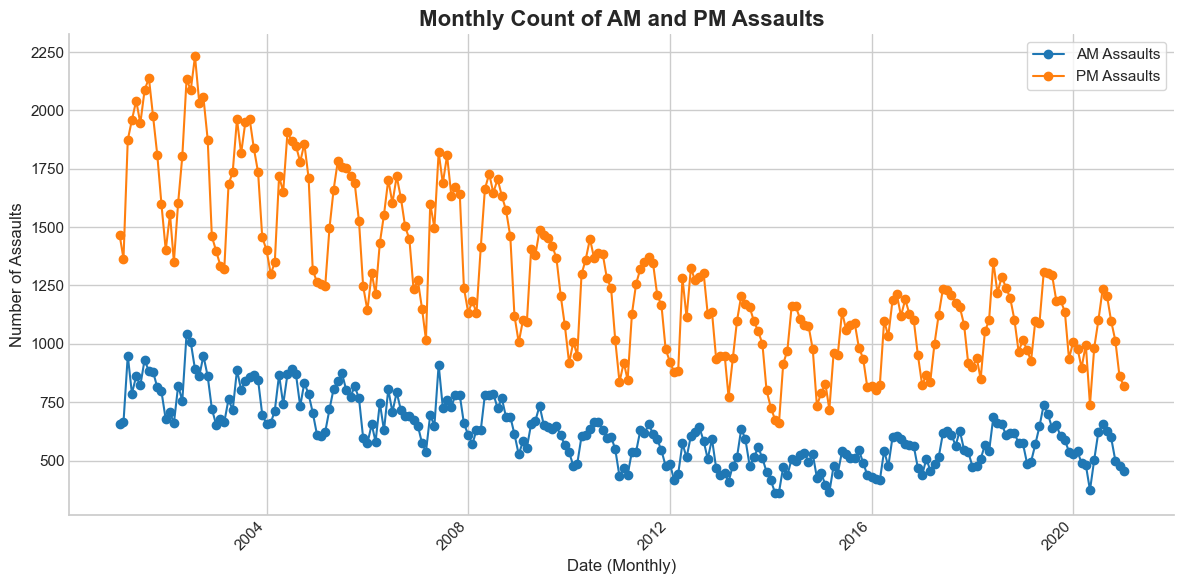

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have calculated the monthly_count_am_assaults and monthly_count_pm_assaults DataFrames as described above

# Filter data up to the end of 2020
monthly_count_am_assaults = monthly_count_am_assaults[monthly_count_am_assaults.index <= '2020-12-31']
monthly_count_pm_assaults = monthly_count_pm_assaults[monthly_count_pm_assaults.index <= '2020-12-31']

# Set the seaborn style to a muted color palette
sns.set(style="whitegrid", palette="muted")

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(monthly_count_am_assaults.index, monthly_count_am_assaults, label='AM Assaults', marker='o', linestyle='-', color='tab:blue')
plt.plot(monthly_count_pm_assaults.index, monthly_count_pm_assaults, label='PM Assaults', marker='o', linestyle='-', color='tab:orange')

# Customize the plot
plt.xlabel('Date (Monthly)')
plt.ylabel('Number of Assaults')
plt.title('Monthly Count of AM and PM Assaults', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tick_params(axis='both', which='both', length=0)  # Remove ticks from both axes
plt.gca().spines['top'].set_visible(False)  # Remove top and right spines
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Display the plot
plt.show()



In [235]:
merged_assault_counts_month = pd.merge(am_assault_count_month, pm_assault_count_month, left_index=True, right_index=True, how='outer')
merged_assault_counts_month.columns
merged_assault_counts_month


,AM Assaults,PM Assaults
Date,,
2001-01-31,657,1466
2001-02-28,664,1365
2001-03-31,950,1874
2001-04-30,787,1959
2001-05-31,861,2042
...,...,...
2023-03-31,619,1136
2023-04-30,660,1147
2023-05-31,753,1257


In [236]:
# Assuming 'data' is the object you want to check
if type(merged_assault_counts_month) == pd.DataFrame:
    print("data is a DataFrame.")
else:
    print("data is not a DataFrame.")

data is a DataFrame.


### Yearly Assault Counts

In [259]:
### DON'T MODIFY!! ###
# This code calculates the yearly count of Assault for AM and PM

# Calculate the yearly count of Assault for AM
# 1. Use the `resample` method to group the DataFrame "am_df" by years ('Y') based on the "Date" column.
am_assault_count_year = am_df.resample('Y', on='Date').count()

# 2. Keep only the year part in the index of "am_assault_count_year" to represent each year.
am_assault_count_year.index = am_assault_count_year.index.year

# 3. Drop the unnecessary column "Time_of_Day" from the DataFrame "am_assault_count_year"
#    as it is not needed for the count.
am_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)

# 4. Rename the column 'Primary Type' to 'AM Assaults' to represent the count of AM assaults for each year.
am_assault_count_year.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the yearly count of Assault for PM
# 5. Use the `resample` method to group the DataFrame "pm_df" by years ('Y') based on the "Date" column.
pm_assault_count_year = pm_df.resample('Y', on='Date').count()

# 6. Keep only the year part in the index of "pm_assault_count_year" to represent each year.
pm_assault_count_year.index = pm_assault_count_year.index.year

# 7. Drop the unnecessary column "Time_of_Day" from the DataFrame "pm_assault_count_year"
#    as it is not needed for the count.
pm_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)

# 8. Rename the column 'Primary Type' to 'PM Assaults' to represent the count of PM assaults for each year.
pm_assault_count_year.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
# 9. Merge the DataFrames "am_assault_count_year" and "pm_assault_count_year" based on their Date index using `pd.merge`.
#    The 'outer' join is used to retain all years from both DataFrames even if some years have no assaults for either AM or PM.
merged_assault_counts_year_am_pm = pd.merge(am_assault_count_year, pm_assault_count_year, left_index=True, right_index=True, how='outer')

# Calculate the yearly count of AM Assaults and PM Assaults
# 10. Extract the columns 'AM Assaults' and 'PM Assaults' from the merged DataFrame
#     "merged_assault_counts_year" to get the yearly count of AM and PM assaults separately.
yearly_count_am_assaults = merged_assault_counts_year_am_pm['AM Assaults']
yearly_count_pm_assaults = merged_assault_counts_year_am_pm['PM Assaults']

# Calculate the total assaults per year by summing AM and PM assaults for each year
assaults_per_year = yearly_count_am_assaults + yearly_count_pm_assaults


# Print the results
# 11. Print the merged DataFrame "merged_assault_counts_year" to display the yearly count of AM and PM assaults.
#     The DataFrame will show NaN values for years where there were no assaults for either AM or PM.
# print("Yearly Count of AM/PM Assaults:")
# print(merged_assault_counts_year_am_pm)


# print("Yearly Count of AM Assaults:")
# print(yearly_count_am_assaults)


print("Yearly Count of PM Assaults:")
print(yearly_count_pm_assaults)

# print("Total Assaults per Year:")
# print(assaults_per_year)

Yearly Count of PM Assaults:
Date
2001    21663
2002    21589
2003    20198
2004    19570
2005    18270
2006    17610
2007    17900
2008    17266
2009    15376
2010    14584
2011    13815
2012    13492
2013    11973
2014    11308
2015    11376
2016    12483
2017    12739
2018    13322
2019    13439
2020    11931
2021    12781
2022    12892
2023     7410
Name: PM Assaults, dtype: int64


Dual Line Plot With Yearly Count of AM and PM Assaults

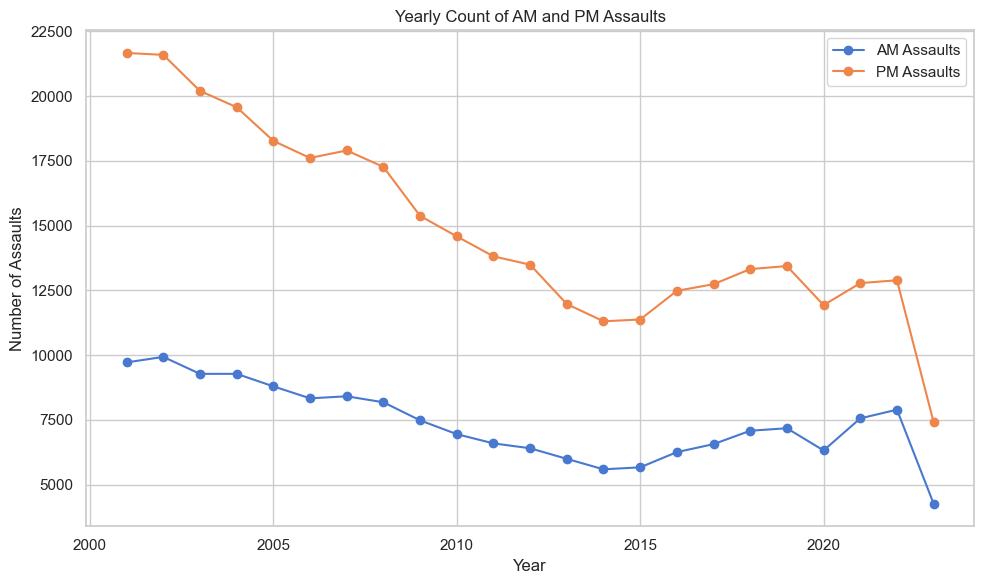

In [238]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(yearly_count_am_assaults.index, yearly_count_am_assaults, label='AM Assaults', marker='o', linestyle='-')
plt.plot(yearly_count_pm_assaults.index, yearly_count_pm_assaults, label='PM Assaults', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Assaults')
plt.title('Yearly Count of AM and PM Assaults')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Yearly Assault Mean AM/PM

In [239]:
### NOT CACULATED CORRECTLY ###


# Calculate the yearly count of Assault for AM
am_assault_count_year = am_df.resample('Y', on='Date').count()
am_assault_count_year.index = am_assault_count_year.index.year  # Keep only the year in the index
am_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)
am_assault_count_year.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the yearly count of Assault for PM
pm_assault_count_year = pm_df.resample('Y', on='Date').count()
pm_assault_count_year.index = pm_assault_count_year.index.year  # Keep only the year in the index
pm_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)
pm_assault_count_year.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
merged_mean_assault_counts_year = pd.merge(am_assault_count_year, pm_assault_count_year, left_index=True, right_index=True, how='outer')

# Calculate the mean for each year and round to 2 decimal places
yearly_mean_am_assaults = []
yearly_mean_pm_assaults = []
for year in merged_assault_counts_year.index:
    year_days = 366 if pd.Timestamp(str(year)).is_leap_year else 365
    mean_am_assaults = merged_assault_counts_year.loc[year, 'AM Assaults'] / year_days
    mean_pm_assaults = merged_assault_counts_year.loc[year, 'PM Assaults'] / year_days
    yearly_mean_am_assaults.append(round(mean_am_assaults, 2))
    yearly_mean_pm_assaults.append(round(mean_pm_assaults, 2))

# Add the calculated mean to the DataFrame
merged_mean_assault_counts_year['Mean AM Assaults'] = yearly_mean_am_assaults
merged_mean_assault_counts_year['Mean PM Assaults'] = yearly_mean_pm_assaults

# Drop 'AM Assaults' and 'PM Assaults' columns from the DataFrame
merged_mean_assault_counts_year.drop(columns=['AM Assaults', 'PM Assaults'], inplace=True)

# Variables for Yearly Count of AM Assaults with Mean and Yearly Count of PM Assaults with Mean
yearly_count_am_assaults_with_mean = merged_mean_assault_counts_year['Mean AM Assaults']
yearly_count_pm_assaults_with_mean = merged_mean_assault_counts_year['Mean PM Assaults']

print("Yearly Mean of AM/PM Assaults:")
print(merged_mean_assault_counts_year)

print("Yearly Mean of AM Assault:")
print(yearly_count_am_assaults_with_mean)

print("Yearly Mean of PM Assault:")
print(yearly_count_pm_assaults_with_mean)



Yearly Mean of AM/PM Assaults:
      Mean AM Assaults  Mean PM Assaults
Date                                    
2001             26.63             59.35
2002             27.22             59.15
2003             25.42             55.34
2004             25.36             53.47
2005             24.10             50.05
2006             22.84             48.25
2007             23.05             49.04
2008             22.36             47.17
2009             20.51             42.13
2010             19.05             39.96
2011             18.07             37.85
2012             17.51             36.86
2013             16.44             32.80
2014             15.33             30.98
2015             15.54             31.17
2016             17.10             34.11
2017             17.99             34.90
2018             19.41             36.50
2019             19.67             36.82
2020             17.28             32.60
2021             20.72             35.02
2022             21.64    

### Dual Lineplot showing Daily Mean of Assaults 2001-2022

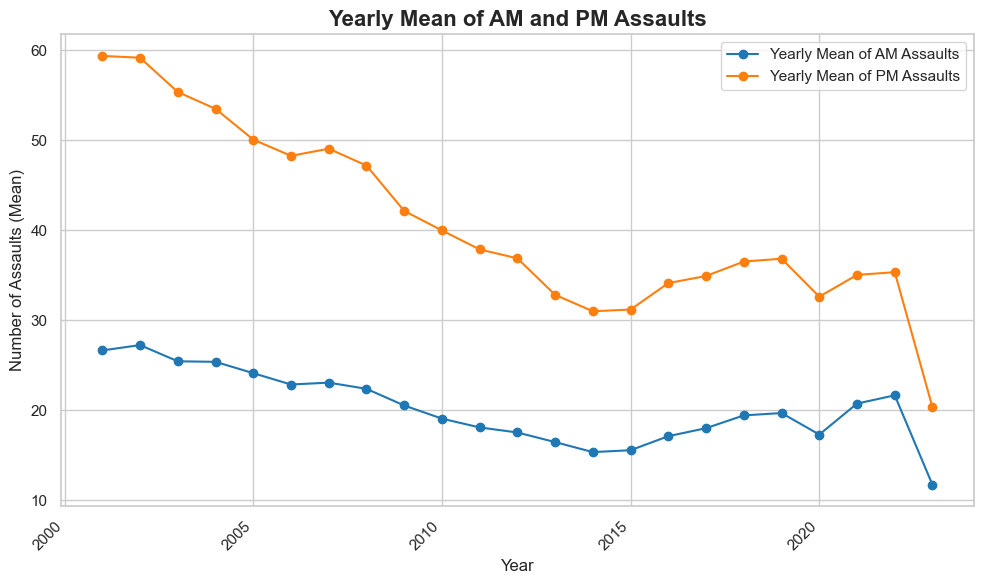

In [240]:
# Create a list of years from the index of the DataFrames
years = yearly_count_am_assaults_with_mean.index

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the yearly mean of AM assaults
plt.plot(years, yearly_count_am_assaults_with_mean, label='Yearly Mean of AM Assaults', marker='o', linestyle='-', color='tab:blue')

# Plot the yearly mean of PM assaults
plt.plot(years, yearly_count_pm_assaults_with_mean, label='Yearly Mean of PM Assaults', marker='o', linestyle='-', color='tab:orange')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Assaults (Mean)')
plt.title('Yearly Mean of AM and PM Assaults', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


### Monthly Assault Mean

In [241]:
### DON'T MODIFY!!! ###
# This code calculates the monthly count of Assault for AM and PM, along with the mean assaults for each month,
# and the yearly count of Assault for AM and PM, along with the mean assaults for each year.

# Calculate the monthly count of Assault for AM
# 1. Use the `resample` method to group the DataFrame "am_df" by months ('M') based on the "Date" column.
am_assault_count_month = am_df.resample('M', on='Date').count()

# 2. Keep only the year and month part in the index of "am_assault_count_month" to represent each month.
am_assault_count_month.index = am_assault_count_month.index.strftime('%Y-%m')

# 3. Drop the unnecessary column "Time_of_Day" from the DataFrame "am_assault_count_month"
#    as it is not needed for the count.
am_assault_count_month.drop(columns=['Time_of_Day'], inplace=True)

# 4. Rename the column 'Primary Type' to 'AM Assaults' to represent the count of AM assaults for each month.
am_assault_count_month.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the monthly count of Assault for PM
# 5. Use the `resample` method to group the DataFrame "pm_df" by months ('M') based on the "Date" column.
pm_assault_count_month = pm_df.resample('M', on='Date').count()

# 6. Keep only the year and month part in the index of "pm_assault_count_month" to represent each month.
pm_assault_count_month.index = pm_assault_count_month.index.strftime('%Y-%m')

# 7. Drop the unnecessary column "Time_of_Day" from the DataFrame "pm_assault_count_month"
#    as it is not needed for the count.
pm_assault_count_month.drop(columns=['Time_of_Day'], inplace=True)

# 8. Rename the column 'Primary Type' to 'PM Assaults' to represent the count of PM assaults for each month.
pm_assault_count_month.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
# 9. Merge the DataFrames "am_assault_count_month" and "pm_assault_count_month" based on their Date index using `pd.merge`.
#    The 'outer' join is used to retain all months from both DataFrames even if some months have no assaults for either AM or PM.
merged_assault_counts_month_mean = pd.merge(am_assault_count_month, pm_assault_count_month, left_index=True, right_index=True, how='outer')

# Calculate the mean for each month and round to 2 decimal places
# 10. Loop through the rows of the DataFrame "merged_assault_counts_month_mean" and calculate the mean assaults for each month.
#     The mean assaults are calculated by dividing the number of assaults for each AM and PM by the number of days in the corresponding month.
#     The calculated means are then rounded to 2 decimal places.
monthly_mean_am_assaults = []
monthly_mean_pm_assaults = []
for index, row in merged_assault_counts_month_mean.iterrows():
    year, month = map(int, index.split('-'))
    year_days = 366 if pd.Timestamp(f'{year}-01-01').is_leap_year else 365
    days_in_month = monthrange(year, month)[1]
    mean_am_assaults = row['AM Assaults'] / days_in_month
    mean_pm_assaults = row['PM Assaults'] / days_in_month
    monthly_mean_am_assaults.append(round(mean_am_assaults, 2))
    monthly_mean_pm_assaults.append(round(mean_pm_assaults, 2))

# Add the calculated mean to the DataFrame
# 11. Add the calculated mean assaults to the DataFrame "merged_assault_counts_month_mean"
#     as two new columns 'Mean AM Assaults' and 'Mean PM Assaults'.
merged_assault_counts_month_mean['Mean AM Assaults'] = monthly_mean_am_assaults
merged_assault_counts_month_mean['Mean PM Assaults'] = monthly_mean_pm_assaults

# Calculate the yearly count of Assault for AM
# 12. Calculate the yearly count of Assault for AM similar to the previous steps.
am_assault_count_year = am_df.resample('Y', on='Date').count()
am_assault_count_year.index = am_assault_count_year.index.year  # Keep only the year in the index
am_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)
am_assault_count_year.rename(columns={'Primary Type': 'AM Assaults'}, inplace=True)

# Calculate the yearly count of Assault for PM
# 13. Calculate the yearly count of Assault for PM similar to the previous steps.
pm_assault_count_year = pm_df.resample('Y', on='Date').count()
pm_assault_count_year.index = pm_assault_count_year.index.year  # Keep only the year in the index
pm_assault_count_year.drop(columns=['Time_of_Day'], inplace=True)
pm_assault_count_year.rename(columns={'Primary Type': 'PM Assaults'}, inplace=True)

# Merge the AM and PM assault counts based on the Date index
# 14. Merge the DataFrames "am_assault_count_year" and "pm_assault_count_year" based on their Date index using `pd.merge`.
#     The 'outer' join is used to retain all years from both DataFrames even if some years have no assaults for either AM or PM.
merged_assault_counts_year_mean = pd.merge(am_assault_count_year, pm_assault_count_year, left_index=True, right_index=True, how='outer')

# Calculate the mean for each year and round to 2 decimal places
# 15. Loop through the rows of the DataFrame "merged_assault_counts_year_mean" and calculate the mean assaults for each year.
#     The mean assaults are calculated by dividing the number of assaults for each AM and PM by the number of days in the corresponding year.
#     The calculated means are then rounded to 2 decimal places.
yearly_mean_am_assaults = []
yearly_mean_pm_assaults = []
for year, row in merged_assault_counts_year_mean.iterrows():
    # Calculate the total number of days in the current year.
    # 1. Check if the first day of the year (January 1st) is a leap year (366 days) or not (365 days).
    #    The 'pd.Timestamp(f'{year}-01-01').is_leap_year' function determines if the year is a leap year or not.
    #    If it is a leap year, "year_days" is set to 366; otherwise, it is set to 365.
    year_days = 366 if pd.Timestamp(f'{year}-01-01').is_leap_year else 365

    # Calculate the mean number of AM assaults for the current year.
    # 2. Divide the total number of AM assaults in the current year (row['AM Assaults']) by the total number of days in the year (year_days).
    #    This gives the average number of AM assaults per day for the current year.
    mean_am_assaults = row['AM Assaults'] / year_days

    # Calculate the mean number of PM assaults for the current year.
    # 3. Divide the total number of PM assaults in the current year (row['PM Assaults']) by the total number of days in the year (year_days).
    #    This gives the average number of PM assaults per day for the current year.
    mean_pm_assaults = row['PM Assaults'] / year_days

    # Append the calculated mean values to the lists for each year.
    # 4. Append the calculated mean AM assaults and mean PM assaults to the respective lists.
    #    The mean values are rounded to 2 decimal places using the `round` function before appending.
    yearly_mean_am_assaults.append(round(mean_am_assaults, 2))
    yearly_mean_pm_assaults.append(round(mean_pm_assaults, 2))

# Add the calculated mean to the DataFrame
# 16. Add the calculated mean assaults to the DataFrame "merged_assault_counts_year_mean"
#     as two new columns 'Mean AM Assaults By Year' and 'Mean PM Assaults By Year'.
merged_assault_counts_year_mean['Mean AM Assaults By Year'] = yearly_mean_am_assaults
merged_assault_counts_year_mean['Mean PM Assaults By Year'] = yearly_mean_pm_assaults

# Store the variables for later use
# 17. Store the mean assaults for each year in separate variables for later use.
mean_am_assaults_by_year = merged_assault_counts_year_mean['Mean AM Assaults By Year']
mean_pm_assaults_by_year = merged_assault_counts_year_mean['Mean PM Assaults By Year']

# Print the results
# 18. Print the monthly count of AM and PM assaults with mean for each month.
print("Monthly Count of AM/PM Assaults with Mean:")
print(merged_assault_counts_month_mean)

# 19. Print the mean AM assaults for each year.
print("Mean AM Assaults By Year:")
print(mean_am_assaults_by_year)

# 20. Print the mean PM assaults for each year.
print("Mean PM Assaults By Year:")
print(mean_pm_assaults_by_year)

# Manually Checked Calculations
# 21. The sample calculation for January 2001: 657 Assaults / 31 Days in January is 21.19.



Monthly Count of AM/PM Assaults with Mean:
         AM Assaults  PM Assaults  Mean AM Assaults  Mean PM Assaults
Date                                                                 
2001-01          657         1466             21.19             47.29
2001-02          664         1365             23.71             48.75
2001-03          950         1874             30.65             60.45
2001-04          787         1959             26.23             65.30
2001-05          861         2042             27.77             65.87
...              ...          ...               ...               ...
2023-03          619         1136             19.97             36.65
2023-04          660         1147             22.00             38.23
2023-05          753         1257             24.29             40.55
2023-06          736         1278             24.53             42.60
2023-07          328          572             10.58             18.45

[271 rows x 4 columns]
Mean AM Assaults By Yea

In [242]:
import pandas as pd

# Convert the "Date" column to a pandas datetime object
crime_df["Date"] = pd.to_datetime(crime_df["Date"], format='%m/%d/%Y %I:%M:%S %p')

# Create a DataFrame containing only the rows with Primary Type "ASSAULT" and relevant columns
assault_with_date = crime_df.loc[crime_df["Primary Type"] == "ASSAULT", ["Date", "Primary Type", "Arrest"]]

# Create "Time_of_Day" feature to store whether the crime occurred in the AM or PM
assault_with_date["Time_of_Day"] = assault_with_date["Date"].dt.strftime('%p')

# Count the occurrence of AM and PM assaults
assault_counts = assault_with_date["Time_of_Day"].value_counts()
assaults_am = assault_counts.loc["AM"]
assaults_pm = assault_counts.loc["PM"]

# Print the number of assaults that occurred in the AM and PM
print("Number of Assaults in the AM:", assaults_am)
print("Number of Assaults in the PM:", assaults_pm)

# Create dummy variables for the "Arrest" column
assault_with_date = pd.get_dummies(assault_with_date, columns=['Arrest'], prefix=['Arrest'])

# Calculate the daily count of AM Assaults and PM Assaults
daily_count_am_assaults = assault_with_date[assault_with_date['Time_of_Day'] == 'AM'].groupby(assault_with_date['Date'].dt.date)['Arrest_True'].sum()
daily_count_pm_assaults = assault_with_date[assault_with_date['Time_of_Day'] == 'PM'].groupby(assault_with_date['Date'].dt.date)['Arrest_True'].sum()

# Calculate the daily count of AM Assault arrests and non-arrests
am_arrest_count_by_day = assault_with_date[assault_with_date['Time_of_Day'] == 'AM'].groupby(assault_with_date['Date'].dt.date)['Arrest_True'].sum()
am_non_arrest_count_by_day = assault_with_date[(assault_with_date['Time_of_Day'] == 'AM') & (assault_with_date['Arrest_False'] == 1)].groupby(assault_with_date['Date'].dt.date)['Arrest_False'].sum()

# Calculate the daily count of PM Assault arrests and non-arrests
pm_arrest_count_by_day = assault_with_date[assault_with_date['Time_of_Day'] == 'PM'].groupby(assault_with_date['Date'].dt.date)['Arrest_True'].sum()
pm_non_arrest_count_by_day = assault_with_date[(assault_with_date['Time_of_Day'] == 'PM') & (assault_with_date['Arrest_False'] == 1)].groupby(assault_with_date['Date'].dt.date)['Arrest_False'].sum()

# Create a DataFrame with all the daily counts
daily_counts = pd.DataFrame({
    'AM Assaults': daily_count_am_assaults,
    'PM Assaults': daily_count_pm_assaults,
    'AM Arrests': am_arrest_count_by_day,
    'AM Not Arrests': am_non_arrest_count_by_day,
    'PM Arrests': pm_arrest_count_by_day,
    'PM Not Arrests': pm_non_arrest_count_by_day
})

# Fill NaN values (occurs when there are no arrests for a specific time of day) with 0
daily_counts.fillna(0, inplace=True)

daily_counts.head(10)



Number of Assaults in the AM: 169790
Number of Assaults in the PM: 342987


,AM Assaults,PM Assaults,AM Arrests,AM Not Arrests,PM Arrests,PM Not Arrests
Date,,,,,,
2001-01-01,10,10,10,21,10,29
2001-01-02,7,8,7,13,8,38
2001-01-03,1,14,1,17,14,47
2001-01-04,3,11,3,15,11,28
2001-01-05,6,11,6,16,11,35
2001-01-06,2,11,2,12,11,42
2001-01-07,1,7,1,17,7,36
2001-01-08,4,10,4,15,10,38
2001-01-09,1,10,1,19,10,33


In [243]:
# Variables to use for later
am_assault_count

pm_assault_count

print("Daily Count of AM/PM Assaults:")
print(merged_assault_counts_day)

print("Daily Count of AM Assaults:")
print(daily_count_am_assaults)

print("Daily Count of PM Assaults:")
print(daily_count_pm_assaults)


print("Monthly Count of AM/PM Assaults:")
print(merged_assault_counts_month)

print("Monthly Count of AM Assaults:")
print(monthly_count_am_assaults)

print("Monthly Count of PM Assaults:")
print(monthly_count_pm_assaults)

print("Yearly Count of AM/PM Assaults:")
print(merged_assault_counts_year)

print("Yearly Count of AM Assaults:")
print(yearly_count_am_assaults)

print("Yearly Count of PM Assaults:")
print(yearly_count_pm_assaults)

print("Yearly Mean of AM/PM Assaults:")
print(merged_mean_assault_counts_year)

print("Yearly Mean of AM Assault:")
print(yearly_count_am_assaults_with_mean)

print("Yearly Mean of PM Assault:")
print(yearly_count_pm_assaults_with_mean)

print("Monthly Count of AM/PM Assaults with Mean:")
print(merged_assault_counts_month_mean)

print("Mean AM Assaults By Year:")
print(mean_am_assaults_by_year)

print("Mean PM Assaults By Year:")
print(mean_pm_assaults_by_year)

Daily Count of AM/PM Assaults:
            Date_x  AM Assaults  Time_of_Day_x  Date_y  PM Assaults  \
Date                                                                  
2001-01-01      31           31             31      39           39   
2001-01-02      20           20             20      46           46   
2001-01-03      18           18             18      61           61   
2001-01-04      18           18             18      39           39   
2001-01-05      22           22             22      46           46   
...            ...          ...            ...     ...          ...   
2023-07-10      27           27             27      39           39   
2023-07-11      22           22             22      40           40   
2023-07-12      21           21             21      42           42   
2023-07-13      21           21             21      44           44   
2023-07-14      27           27             27      43           43   

            Time_of_Day_y  
Date             

### Linear Regression Model for Total Assaults Per Year

Linear Regression Results:
Intercept: 1335385.0988142057
Slope (Year coefficient): -652.6294466403044


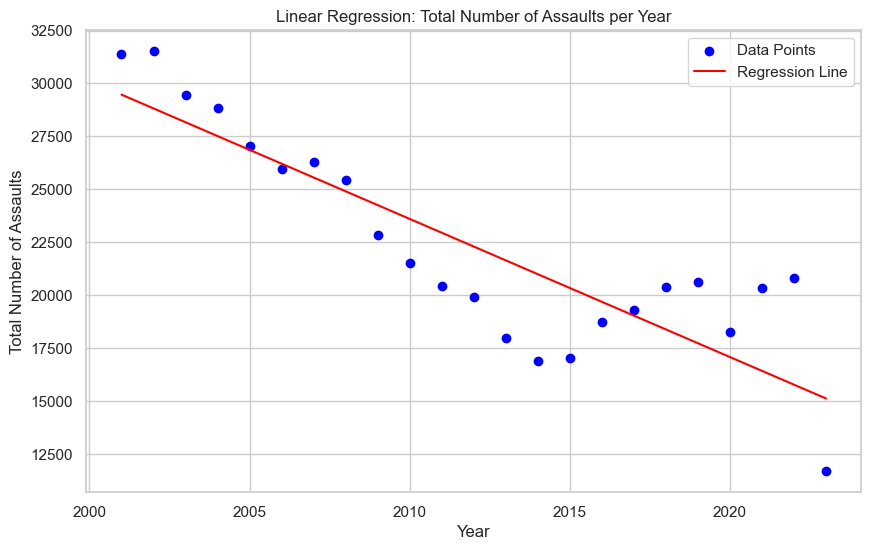

In [244]:
# Replace 'your_data.csv' with the path to your actual CSV file containing the data
crime_df = pd.read_pickle('../data/pickled_df.pkl')

# Step 1: Prepare the Data
# Extract the total number of assaults per year
assaults_per_year_lr = assaults_per_year

# Create a DataFrame with the year and total number of assaults
df = pd.DataFrame({'Year': assaults_per_year_lr.index, 'Total Assults': assaults_per_year_lr.values})

# Step 2: Perform Linear Regression
# Add a constant term for the intercept
X = sm.add_constant(df['Year'])
y = df['Total Assults']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Step 3: Interpret the Results
# Get the coefficients and intercept
coefficients = model.params
intercept = coefficients['const']
slope = coefficients['Year']

print("Linear Regression Results:")
print("Intercept:", intercept)
print("Slope (Year coefficient):", slope)

# Step 4: Visualize the Results
plt.figure(figsize=(10, 6))
plt.scatter(df['Year'], df['Total Assults'], label='Data Points', color='blue')
plt.plot(df['Year'], intercept + slope * df['Year'], label='Regression Line', color='red')
plt.xlabel('Year')
plt.ylabel('Total Number of Assaults')
plt.title('Linear Regression: Total Number of Assaults per Year')
plt.legend()
plt.grid(True)
plt.show()


### Linear Regression Model For Total Assaults Per Month

Linear Regression Results:
Intercept: 98991.6873129841
Slope (Year coefficient): -48.26506796959387


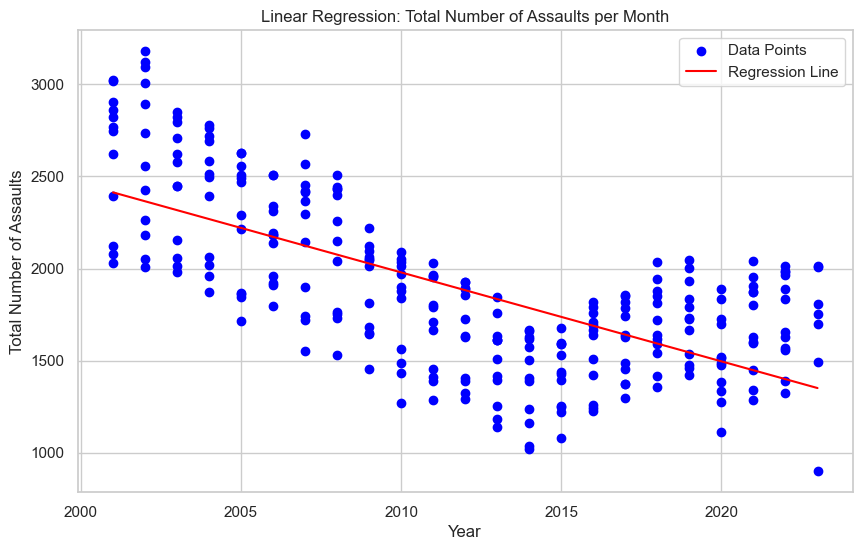

In [245]:
# Replace 'your_data.csv' with the path to your actual CSV file containing the data
crime_df = pd.read_pickle('../data/pickled_df.pkl')

# Step 1: Prepare the Data
# Extract the total number of assaults per month
assaults_per_month_lr = total_assaults_per_month

# Create a DataFrame with the year and total number of assaults
df = pd.DataFrame({'Year': assaults_per_month_lr.index.year, 'Total Assaults': assaults_per_month_lr.values})

# Step 2: Perform Linear Regression
# Add a constant term for the intercept
X = sm.add_constant(df['Year'])
y = df['Total Assaults']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Step 3: Interpret the Results
# Get the coefficients and intercept
coefficients = model.params
intercept = coefficients['const']
slope = coefficients['Year']

print("Linear Regression Results:")
print("Intercept:", intercept)
print("Slope (Year coefficient):", slope)

# Step 4: Visualize the Results
plt.figure(figsize=(10, 6))
plt.scatter(df['Year'], df['Total Assaults'], label='Data Points', color='blue')
plt.plot(df['Year'], intercept + slope * df['Year'], label='Regression Line', color='red')
plt.xlabel('Year')
plt.ylabel('Total Number of Assaults')
plt.title('Linear Regression: Total Number of Assaults per Month')
plt.legend()
plt.grid(True)
plt.show()


### Linear Regression Model For Total Assaults Per Day

Linear Regression Results:
Intercept: 3201.9338781358647
Slope (Year coefficient): -1.5606275585003113


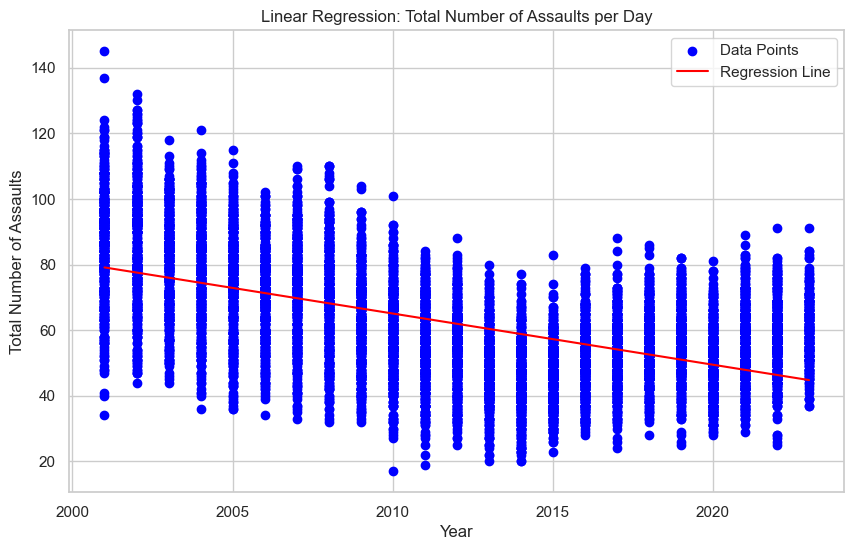

In [246]:
# Replace 'your_data.csv' with the path to your actual CSV file containing the data
crime_df = pd.read_pickle('../data/pickled_df.pkl')

# Step 1: Prepare the Data
# Extract the total number of assaults per year
assaults_per_day_lr = total_assaults_per_day

# Convert the date index to a DatetimeIndex
assaults_per_day_lr.index = pd.to_datetime(assaults_per_day_lr.index)

# Create a DataFrame with the year and total number of assaults
df = pd.DataFrame({'Year': assaults_per_day_lr.index.year, 'Total Assaults': assaults_per_day_lr.values})

# Step 2: Perform Linear Regression
# Add a constant term for the intercept
X = sm.add_constant(df['Year'])
y = df['Total Assaults']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Step 3: Interpret the Results
# Get the coefficients and intercept
coefficients = model.params
intercept = coefficients['const']
slope = coefficients['Year']

print("Linear Regression Results:")
print("Intercept:", intercept)
print("Slope (Year coefficient):", slope)

# Step 4: Visualize the Results
plt.figure(figsize=(10, 6))
plt.scatter(df['Year'], df['Total Assaults'], label='Data Points', color='blue')
plt.plot(df['Year'], intercept + slope * df['Year'], label='Regression Line', color='red')
plt.xlabel('Year')
plt.ylabel('Total Number of Assaults')
plt.title('Linear Regression: Total Number of Assaults per Day')
plt.legend()
plt.grid(True)
plt.show()


In [247]:
# Filter rows where 'Primary Type' is 'Assault'
assault_locations = crime_df[crime_df['Primary Type'] == 'ASSAULT']

# Get the count of occurrences for each unique 'Location Description' where 'THEFT' occurs
assault_locations_count = assault_locations['Location Description'].value_counts().reset_index()
assault_locations_count.columns = ['Location Description', 'Count']

# Sort the DataFrame by 'Count' in descending order
assault_locations_count_sorted = assault_locations_count.sort_values(by='Count', ascending=False)

# Get the top 10 locations where 'ASSAULT' crimes occur
top_10_locations_assault = assault_locations_count_sorted.head(10)

# Print the resulting table with tabulate
print("Top 10 Locations for ASSAULT:")
print(tabulate(top_10_locations_assault, headers='keys', tablefmt='pretty', showindex=False))

Top 10 Locations for ASSAULT:
+--------------------------------+--------+
|      Location Description      | Count  |
+--------------------------------+--------+
|             STREET             | 104752 |
|           RESIDENCE            | 86559  |
|           APARTMENT            | 71551  |
|            SIDEWALK            | 64457  |
|    SCHOOL, PUBLIC, BUILDING    | 25600  |
|    RESIDENCE PORCH/HALLWAY     | 17830  |
|             OTHER              | 15647  |
|             ALLEY              | 11876  |
|           RESTAURANT           | 10643  |
| PARKING LOT/GARAGE(NON.RESID.) |  7956  |
+--------------------------------+--------+


### Correlation Matrix for Assaults and Location

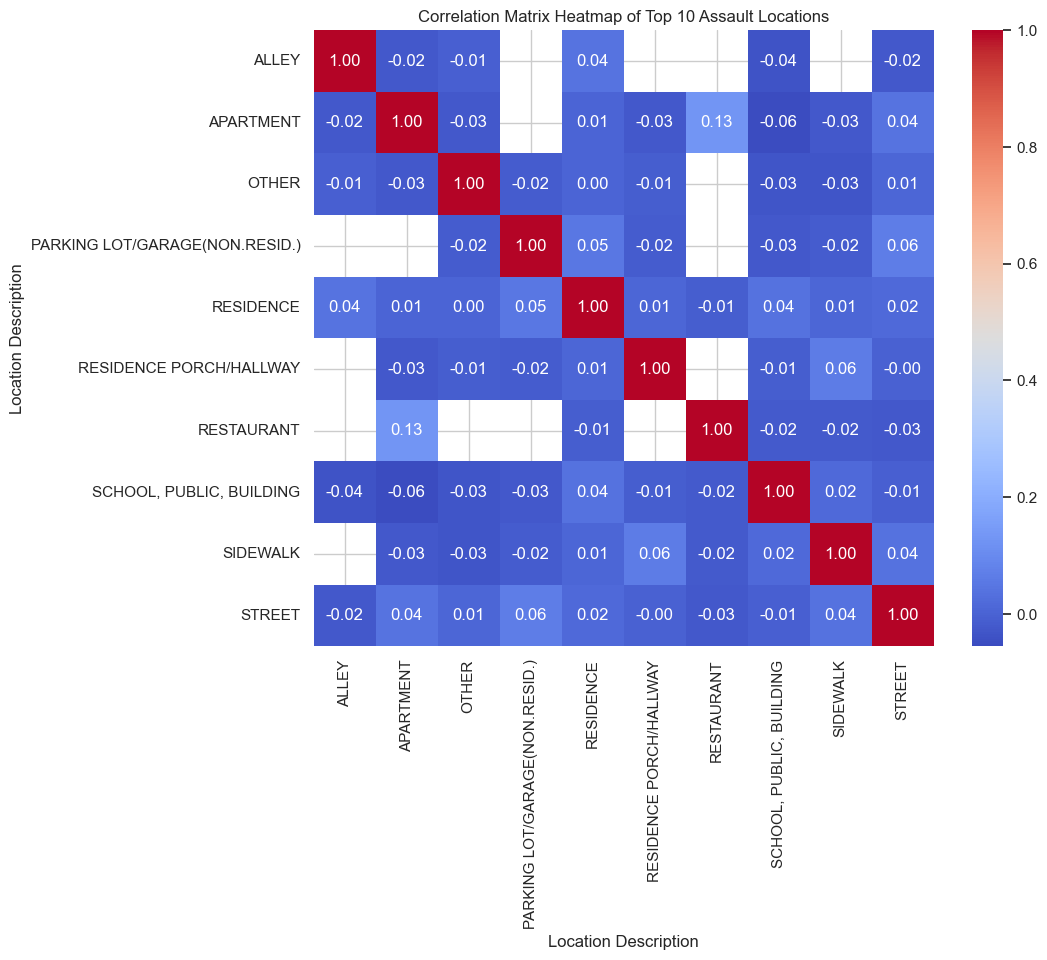

In [248]:
# Replace 'your_data.csv' with the path to your actual CSV file containing the data
crime_df = pd.read_pickle('../data/pickled_df.pkl')

# Filter rows where 'Primary Type' is 'Assault'
assault_locations = crime_df[crime_df['Primary Type'] == 'ASSAULT']

# Get the count of occurrences for each unique 'Location Description' where 'ASSAULT' occurs
assault_locations_count = assault_locations['Location Description'].value_counts().reset_index()
assault_locations_count.columns = ['Location Description', 'Count']

# Sort the DataFrame by 'Count' in descending order
assault_locations_count_sorted = assault_locations_count.sort_values(by='Count', ascending=False)

# Get the top 10 locations where 'ASSAULT' crimes occur
top_10_locations_assault = assault_locations_count_sorted.head(10)

# Filter the assault_locations DataFrame to include only the top 10 locations
assault_locations_top_10 = assault_locations[assault_locations['Location Description'].isin(top_10_locations_assault['Location Description'])]

# Create a pivot table to get the count of occurrences for each 'Location Description' for each month
assault_locations_pivot = assault_locations_top_10.pivot_table(index='Date', columns='Location Description', values='ID', aggfunc='count')

# Calculate the correlation matrix
correlation_matrix = assault_locations_pivot.corr(numeric_only=True)

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap of Top 10 Assault Locations")
plt.show()


pull out am and pm, pull out just Assaults that Domestic Violence Yes or No
from the assaults how many have domesitic violence
can we use this other iformation based on location can we use other columsn to help determine if these things will affect getting arresting
if there is assault and subset by domestic, predict 

ask for all crimes for domestic

step: have assault DF
### cut out? 2) pull out domestic violence = yes 
3) for all variables that are categrotical, use get dummies to get 1s 0s 
4) drop one of the columns for every one of the get dummies (most common)
5) is theft   is murder  is narcotic
     1           0            0
     0           1            0
     0           0            1
6) after get dummies drop column that is most common, the one with the most ones drop it
7) arrest = y x = use all other useful columns as features, drop the uncessary ones like ID, Case number, IUCR, ward, community area, coordinates, updated on, beat, fbi code
8) identify y and x values
9) train,test,split I will need help
9) perform logic regression and fit on training values with target being y values which arrest
11) after fit use x test values to get new predictions for y and see how well your model predicted your values
12) from model get coef and that will help determine which column had the strongest effect if something resulted in arrest

In [264]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

#### The correlation matrix visually displays the relationships between the top 10 assault locations.

- Positive correlation (closer to 1) indicates locations with similar assault trends.
- Negative correlation (closer to -1) suggests locations with opposite assault trends.
- Correlation close to 0 shows no significant relationship between locations.

###### When we see a positive number in the correlation matrix, it means that assaults are more likely to occur at those locations together. For example, if we have a correlation of 0.8 between Location A and Location B, it suggests that when an assault happens at Location A, there is a higher chance of another assault occurring at Location B, and vice versa.

###### On the other hand, when we see a negative number in the correlation matrix, it means that assaults are less likely to occur at those locations together. For instance, if we have a correlation of -0.6 between Location C and Location D, it indicates that when an assault happens at Location C, there is a lower chance of another assault occurring at Location D, and vice versa.

###### A correlation close to 0 means that there is no strong relationship between the occurrences of assaults at the two locations. In such cases, the assaults happening at one location don't significantly influence the likelihood of assaults happening at the other location.

#### Here's a summary of the results:
##### Positive Correlation (values close to 1):
###### Alley and Residence: There is a slightly positive correlation between assaults in alleys and residences.
###### Apartment and Resturant: There is a moderate positive correlation between assaults in apartments and restaurants.
###### Parking Lot/Garage(NON.RESID.) and Street: There is a slightly positive correlation between assaults in parking lots/garages and on the street.
##### Negative Correlation (values close to -1):
###### Alley and Apartment: There is a very weak negative correlation between assaults in alleys and apartments.
##### Weak Correlation (values close to 0):
###### Most of the other correlations have weak or close-to-zero values, indicating little to no linear relationship between assaults at those locations.
###### Missing Data: Some correlations have NaN values, which means there were no data points or valid comparisons between those specific location descriptions.


In [249]:
yearly_count_am_assaults
yearly_count_pm_assaults

Date
2001    21663
2002    21589
2003    20198
2004    19570
2005    18270
2006    17610
2007    17900
2008    17266
2009    15376
2010    14584
2011    13815
2012    13492
2013    11973
2014    11308
2015    11376
2016    12483
2017    12739
2018    13322
2019    13439
2020    11931
2021    12781
2022    12892
2023     7410
Name: PM Assaults, dtype: int64

In [253]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the Series 'yearly_count_am_assaults' and 'yearly_count_pm_assaults'
# If not, you can create them from the provided data
# yearly_count_am_assaults = pd.Series([9721, 9934, 9279, ...], index=[2001, 2002, 2003, ...])
# yearly_count_pm_assaults = pd.Series([21663, 21589, 20198, ...], index=[2001, 2002, 2003, ...])

# Convert the Series to DataFrames and reset index
yearly_count_am_assaults_df = yearly_count_am_assaults.reset_index()
yearly_count_pm_assaults_df = yearly_count_pm_assaults.reset_index()

# Merge the AM and PM DataFrames based on the 'Year' column
merged_assault_counts_year_am_pm = pd.merge(yearly_count_am_assaults_df, yearly_count_pm_assaults_df, on='Year', suffixes=('_AM', '_PM'))

# Set up the seaborn style
sns.set_theme(style="whitegrid")

# Create the grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_assault_counts_year_am_pm, x='Year', y='AM Assaults', color='blue', label='AM Assaults')
sns.barplot(data=merged_assault_counts_year_am_pm, x='Year', y='PM Assaults', color='red', label='PM Assaults')
plt.xlabel('Year')
plt.ylabel('Assaults Count')
plt.title('Yearly AM and PM Assaults')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to prevent overlap of labels
plt.show()




KeyError: 'Year'